In [ ]:
# Imports and Configuration
import numpy as np
import pandas as pd
from copy import deepcopy
from itertools import combinations
import warnings
import gc
import optuna
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

# Machine Learning
import miceforest as mf
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight
from lightgbm import LGBMClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Configuration
SEED = 1516
np.random.seed(SEED)

# Data Loading

In [2]:
# Load and Prepare Data
train = pd.read_csv('train.csv')

# Define target mapping for pH classes
target_map = {
    "Strongly acidic": -2,
    "Moderately acidic": -1,
    "Neutral": 0,
    "Moderately alkaline": 1,
    "Strongly alkaline": 2
}

# Select numeric columns (excluding ID and target)
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['ID', 'Class.pH']]

# Prepare features and target
y_train = train['Class.pH'].astype(str).str.strip().map(target_map)
valid_idx = ~y_train.isna()
X_train = train.loc[valid_idx, numeric_cols].reset_index(drop=True)
y_train = y_train.loc[valid_idx].astype(int).reset_index(drop=True)

print("Unique classes after mapping:", sorted(y_train.unique()))
print("Any NaNs left in y_train?", y_train.isna().sum())

Unique classes after mapping: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2)]
Any NaNs left in y_train? 0


# Feature Engineering

In [3]:
# Feature Engineering Function
def add_soil_features(X):
    """
    Add domain-specific soil chemistry features
    """
    X_new = X.copy()
    
    # Base saturation features
    for cat in ["Ca", "Mg", "K", "Na"]:
        X_new[f"{cat}_BS"] = np.where(X_new["CEC"] != 0, X_new[cat] / X_new["CEC"], 0)
    
    X_new["BS_Total"] = np.where(
        X_new["CEC"] != 0,
        (X_new["Ca"] + X_new["Mg"] + X_new["K"] + X_new["Na"]) / X_new["CEC"],
        0,
    )
    
    # Nutrient ratios
    X_new["Ca_Mg_Ratio"] = np.where(X_new["Mg"] != 0, X_new["Ca"] / X_new["Mg"], 0)
    X_new["Ca_K_Ratio"] = np.where(X_new["K"] != 0, X_new["Ca"] / X_new["K"], 0)
    X_new["Clay_Sand_Ratio"] = np.where(X_new["SAND"] != 0, X_new["CLAY"] / X_new["SAND"], 0)

    # ESP calculations and differences
    X_new["ESP_calc"] = np.where(X_new["CEC"] != 0, 100 * X_new["Na"] / X_new["CEC"], 0)
    X_new["ESP_diff"] = X_new["ESP"] - X_new["ESP_calc"]

    # SAR calculations and differences
    X_new["SAR_calc"] = np.where(
        (X_new["Ca"] + X_new["Mg"]) != 0,
        X_new["Na"] / np.sqrt((X_new["Ca"] + X_new["Mg"]) / 2),
        0,
    )
    X_new["SAR_diff"] = X_new["SAR"] - X_new["SAR_calc"]

    # Physical properties
    X_new["OM_BD_Ratio"] = np.where(X_new["BD"] != 0, X_new["OM"] / X_new["BD"], 0)
    X_new["FineFraction"] = X_new["CLAY"] + X_new["SILT"]

    # Log transformations for skewed features
    for col in ["P", "EC", "Na"]:
        X_new[f"log1p_{col}"] = np.log1p(X_new[col].clip(lower=0))

    # Interaction features
    X_new["CaMg_Product"] = X_new["Ca"] * X_new["Mg"]
    X_new["OM_CEC_Product"] = X_new["OM"] * X_new["CEC"]

    return X_new

## Feature Engineering

This section introduces additional soil chemistry and texture–based features designed to improve the model’s ability to capture relationships influencing soil pH classification.

---

### Engineered Feature Groups

- **Base Saturation Features:**  
  Individual base saturation ratios (`Ca_BS`, `Mg_BS`, `K_BS`, `Na_BS`) and overall `BS_Total` to quantify the proportion of exchangeable bases relative to CEC.  
  _Interpretation:_ Higher base saturation generally indicates more alkaline soils.

- **Nutrient Ratios:**  
  `Ca_Mg_Ratio`, `Ca_K_Ratio`, and `Clay_Sand_Ratio` to capture nutrient balance and texture proportion.  
  _Interpretation:_ Imbalances in these ratios can signal nutrient deficiencies or toxicities that affect pH.

- **ESP & SAR Derived Metrics:**  
  Calculated `ESP_calc`, `ESP_diff`, `SAR_calc`, and `SAR_diff` to measure sodium hazard and deviation from expected levels.  
  _Interpretation:_ High ESP/SAR often indicates sodicity, leading to alkaline pH.

- **Physical & Organic Indicators:**  
  `OM_BD_Ratio` as a proxy for soil compaction and organic matter influence, and `FineFraction` (CLAY + SILT) as a single texture metric.  
  _Interpretation:_ Captures soil structure effects on water retention and buffering capacity.

- **Transformations & Interaction Terms:**  
  Log-transformed versions of skewed variables (`log1p_P`, `log1p_EC`, `log1p_Na`) and multiplicative interactions (`CaMg_Product`, `OM_CEC_Product`).  
  _Interpretation:_ Highlights nonlinear effects and joint contributions of nutrients.

---

### Practical Implications

1. **Improved Representation:**  
   These features help the model better reflect agronomic knowledge (e.g., base saturation and cation balance).  

2. **Interpretability:**  
   Domain-driven feature design allows direct interpretation of which soil chemistry properties are influencing classification.

3. **Model Performance:**  
   Early experiments show a performance boost (higher macro-F1) when these features are included before model training.

---

### Summary

Feature engineering extends the raw dataset with **chemically meaningful indicators** and **interaction terms**, leading to better interpretability and potential performance gains. This aligns the model more closely with soil science principles and supports explainable predictions.


In [4]:
# Pipeline with SimpleImputer (Median)
pipe_median = Pipeline([
    ("fe", FunctionTransformer(add_soil_features, validate=False)),
    ("imputer", SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("lgbmc", LGBMClassifier(class_weight="balanced", random_state=SEED))
])

In [5]:
# MICE-based preprocessing (per fold)
def mice_impute_fold(X_tr, X_val, n_iter=5):
    kernel = mf.ImputationKernel(X_tr, random_state=SEED)
    kernel.mice(n_iter)
    X_tr_imp = kernel.complete_data(dataset=0)
    X_val_imp = kernel.impute_new_data(X_val).complete_data(dataset=0)
    return X_tr_imp, X_val_imp

In [6]:
# Cross-validation function
def run_cv_with_pipeline(X, y, pipeline, use_mice=False, n_iter=5):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    f1_scores = []
    y_oof = np.zeros(len(X), dtype=int)

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X, y), 1):
        X_tr, X_val = X.iloc[tr_idx].reset_index(drop=True), X.iloc[va_idx].reset_index(drop=True)
        y_tr, y_val = y.iloc[tr_idx], y.iloc[va_idx]

        if use_mice:
            X_tr, X_val = mice_impute_fold(X_tr, X_val, n_iter=n_iter)

        pipeline.fit(X_tr, y_tr)
        y_pred = pipeline.predict(X_val)

        fold_f1 = f1_score(y_val, y_pred, average="macro")
        f1_scores.append(fold_f1)
        y_oof[va_idx] = y_pred

        # print(f"Fold {fold} F1 (macro): {fold_f1:.4f}")

    # print("\n=== Cross-Validation Summary ===")
    # print(f"Mean F1 (macro): {np.mean(f1_scores):.4f} | Std: {np.std(f1_scores):.4f}")
    return y_oof

In [7]:
# Baseline Evaluation: Compare Median vs MICE Imputation
print("=== MEDIAN IMPUTATION RESULTS ===")
y_oof_median = run_cv_with_pipeline(X_train, y_train, pipe_median, use_mice=False)

print("\n=== MICE IMPUTATION RESULTS ===")
y_oof_mice = run_cv_with_pipeline(X_train, y_train, pipe_median, use_mice=True, n_iter=5)

print("\n=== Classification Report (Median) ===")
print(classification_report(y_train, y_oof_median, digits=3))

print("\n=== Classification Report (MICE) ===")
print(classification_report(y_train, y_oof_mice, digits=3))

baseline_f1 = f1_score(y_train, y_oof_median, average="macro")

=== MEDIAN IMPUTATION RESULTS ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6186
[LightGBM] [Info] Number of data points in the train set: 2409, number of used features: 34
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6203
[LightGBM] [Info] Number of data points in the train set: 2409, number of used features: 34
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [

## Imputation Method Comparison

Two imputation strategies were evaluated under the **same preprocessing and modeling pipeline**:

| Method              | Mean F1 (Macro) | Std Dev | Accuracy | Notes |
|--------------------|----------------|---------|----------|-------|
| **Median Imputation** | **0.4934** | 0.0194 | 0.596 | Simpler, faster, and achieves the best performance |
| **MICE (3 Iterations)** | 0.4856 | 0.0208 | 0.595 | Slightly worse F1, slower, more complex |

---

### Key Observations

- **Median imputation outperformed MICE** by approximately **+0.8% F1-macro**.
- MICE failed to provide meaningful gains despite preserving multivariate relationships.
- Classification report shows slightly better recall and F1 across majority and minority classes using median imputation.
- With **low missingness (<4%)**, the complexity of MICE does not translate into performance benefits and may introduce noise.

---

### Final Decision

Given its **higher performance, simplicity, and stability**, **median imputation** was chosen as the final approach for this study.


# Feature Pruning

In [8]:
# =======================================================
# Feature Analysis: VIF + LightGBM Feature Importance
# =======================================================

# Step 1: Feature Engineering + Median Imputation
X_fe = add_soil_features(X_train)
X_fe = pd.DataFrame(SimpleImputer(strategy="median").fit_transform(X_fe), columns=X_fe.columns)

# Step 2: Variance Inflation Factor (VIF)
print("=== Variance Inflation Factor (VIF) ===")
vif_data = pd.DataFrame({
    "feature": X_fe.columns,
    "VIF": [variance_inflation_factor(X_fe.values, i) for i in range(X_fe.shape[1])]
}).sort_values(by="VIF", ascending=False)
print(vif_data)

# Step 3: LightGBM Feature Importance (Gain)
print("\n=== LightGBM Feature Importance (Gain) ===")
lgbm_clf = LGBMClassifier(random_state=SEED)
lgbm_clf.fit(X_fe, y_train)

gain_importances = lgbm_clf.booster_.feature_importance(importance_type="gain")
gain_data = pd.DataFrame({
    "feature": X_fe.columns,
    "GainImportance": gain_importances
}).sort_values(by="GainImportance", ascending=False)
print(gain_data)

# Step 4: Highlight Candidates for Removal
high_vif = vif_data[vif_data["VIF"] > 10]["feature"].tolist()
low_gain = gain_data[gain_data["GainImportance"] < 1e-6]["feature"].tolist()

print("\nFeatures with VIF > 10 (high collinearity):", high_vif)
print("Features with near-zero Gain Importance:", low_gain)


=== Variance Inflation Factor (VIF) ===
            feature           VIF
13              SAR           inf
14              ESP           inf
23         ESP_calc           inf
24         ESP_diff           inf
25         SAR_calc           inf
26         SAR_diff           inf
18            Na_BS           inf
28     FineFraction  1.075143e+06
6              CLAY  4.554112e+05
19         BS_Total  2.813411e+05
5              SILT  1.647609e+05
15            Ca_BS  7.101072e+04
17             K_BS  1.559855e+04
16            Mg_BS  3.144337e+03
1                OM  2.141355e+01
31         log1p_Na  1.655979e+01
11               Na  1.410557e+01
9                Ca  1.149722e+01
27      OM_BD_Ratio  1.145945e+01
29          log1p_P  1.138330e+01
12              CEC  1.134317e+01
10               Mg  7.557792e+00
33   OM_CEC_Product  7.089565e+00
32     CaMg_Product  6.449757e+00
30         log1p_EC  6.014339e+00
4              SAND  5.872032e+00
20      Ca_Mg_Ratio  3.464668e+00
0       

In [ ]:
selected_features = list(add_soil_features(X_train).columns)
current_f1 = baseline_f1
drop_log = []
iteration = 0
improved = True

print(f"Initial Macro-F1: {current_f1:.4f} | Initial Feature Count: {len(selected_features)}")

while improved and len(selected_features) > 1:
    iteration += 1
    improved = False
    print(f"\n=== Iteration {iteration} | Remaining Features: {len(selected_features)} ===")
    
    # Train on current set to get feature importance
    pipe_temp = deepcopy(pipe_median)
    pipe_temp.steps[0] = ("fe", FunctionTransformer(lambda X: add_soil_features(X)[selected_features], validate=False))
    pipe_temp.fit(X_train, y_train)
    
    model = pipe_temp.named_steps["lgbmc"]
    importances = model.booster_.feature_importance(importance_type="gain")
    feat_importance = dict(zip(selected_features, importances))
    
    best_drop = None
    best_f1 = current_f1

    # Evaluate all candidate drops
    for worst_feat, gain in sorted(feat_importance.items(), key=lambda x: x[1]):
        candidate_features = [f for f in selected_features if f != worst_feat]
        pipe_pruned = deepcopy(pipe_median)
        pipe_pruned.steps[0] = ("fe", FunctionTransformer(lambda X: add_soil_features(X)[candidate_features], validate=False))
        
        y_oof_pruned = run_cv_with_pipeline(X_train, y_train, pipe_pruned)
        new_f1 = f1_score(y_train, y_oof_pruned, average="macro")
        
        print(f"Feature: {worst_feat:<15} | Gain={gain:.2f} | F1={new_f1:.4f} | Δ={new_f1 - current_f1:+.4f}")
        
        if new_f1 > best_f1 + 1e-4:
            best_f1 = new_f1
            best_drop = worst_feat

    # If we found an improving drop, commit it
    if best_drop:
        print(f"✅ Dropping {best_drop} improved F1: {current_f1:.4f} → {best_f1:.4f}")
        selected_features.remove(best_drop)
        current_f1 = best_f1
        drop_log.append((best_drop, best_f1 - current_f1))
        improved = True
    else:
        print("❌ No further improvement from dropping any feature.")
        break

print("\n=== Final Stepwise Backward Selection Result ===")
print(f"Selected Features ({len(selected_features)}): {selected_features}")
print(f"Final Macro-F1: {current_f1:.4f}")

Initial Macro-F1: 0.4934 | Initial Feature Count: 34

=== Iteration 1 | Remaining Features: 34 ===
Feature: ESP_calc        | Gain=0.00 | F1=0.4943 | Δ=+0.0008
Feature: log1p_P         | Gain=0.00 | F1=0.4934 | Δ=+0.0000
Feature: log1p_EC        | Gain=0.00 | F1=0.4934 | Δ=+0.0000
Feature: log1p_Na        | Gain=0.00 | F1=0.4934 | Δ=+0.0000
Feature: N               | Gain=344.74 | F1=0.4810 | Δ=-0.0124
Feature: BD              | Gain=370.62 | F1=0.5027 | Δ=+0.0093
Feature: SAR             | Gain=428.55 | F1=0.4903 | Δ=-0.0031
Feature: ESP             | Gain=550.38 | F1=0.4868 | Δ=-0.0066
Feature: Na              | Gain=555.14 | F1=0.4932 | Δ=-0.0003
Feature: Na_BS           | Gain=658.75 | F1=0.4955 | Δ=+0.0021
Feature: ESP_diff        | Gain=706.88 | F1=0.4867 | Δ=-0.0067
Feature: EC              | Gain=721.93 | F1=0.4934 | Δ=+0.0000
Feature: OM              | Gain=774.16 | F1=0.5021 | Δ=+0.0087
Feature: FineFraction    | Gain=980.83 | F1=0.4890 | Δ=-0.0044
Feature: SAR_calc        | 

## 🔍 Stepwise Backward Selection (SBS) Results

**Initial performance:**  
- **Macro-F1:** `0.4934`  
- **Feature count:** `34`

---

### 📉 Iterative Feature Dropping
SBS iteratively evaluated the removal of each feature, dropping the one that maximally improved validation performance per iteration.

| Iteration | Dropped Feature | Δ F1 (macro) | New F1 (macro) |
|----------:|----------------|-------------:|---------------:|
| 1 | **BD** | **+0.0093** | 0.5027 |
| 2+ | – | **No further improvement** | 0.5027 |

---

### ✅ Final SBS Feature Set
- **Selected features (33):**  
`['EC', 'OM', 'P', 'SAND', 'SILT', 'CLAY', 'N', 'K', 'Ca', 'Mg', 'Na', 'CEC', 'SAR', 'ESP', 'Ca_BS', 'Mg_BS', 'K_BS', 'Na_BS', 'BS_Total', 'Ca_Mg_Ratio', 'Ca_K_Ratio', 'Clay_Sand_Ratio', 'ESP_calc', 'ESP_diff', 'SAR_calc', 'SAR_diff', 'OM_BD_Ratio', 'FineFraction', 'log1p_P', 'log1p_EC', 'log1p_Na', 'CaMg_Product', 'OM_CEC_Product']`

- **Final Macro-F1:** `0.5027`  
- **Net Gain:** `+0.0093` vs baseline  

---

### 🧠 Interpretation
- **BD** was the only feature whose removal improved performance.
- Subsequent iterations showed **no measurable improvement**, confirming that the remaining features are valuable or neutral.
- SBS slightly outperformed recursive greedy pruning, likely because it considered *all* candidate drops per iteration before committing.


In [ ]:
# import optuna
# import gc
# import numpy as np
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import RepeatedStratifiedKFold
# from copy import deepcopy
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.metrics import f1_score

# # === Precompute Balanced Weights ===
# classes = np.unique(y_train)
# balanced_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
# balanced_dict = dict(zip(classes, balanced_weights))

# # === Define Repeated Stratified KFold ===
# rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=SEED)

# def objective(trial):
#     params = {
#         "objective": "multiclass",
#         "num_class": len(classes),
#         "boosting_type": "gbdt",
#         "metric": "None",  # We'll use sklearn's F1
#         "verbosity": -1,
#         "random_state": SEED,
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 16, 128),
#         "max_depth": trial.suggest_int("max_depth", -1, 16),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
#         "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
#     }

#     # === Class Weight Search Around Balanced ===
#     tuned_weights = {}
#     for cls in classes:
#         scale = trial.suggest_float(f"class_weight_{cls}", 0.5, 2.0)
#         tuned_weights[int(cls)] = balanced_dict[cls] * scale
#     params["class_weight"] = tuned_weights

#     # === Run CV with Repeated StratifiedKFold ===
#     oof_preds = np.zeros_like(y_train, dtype=int)
#     for train_idx, valid_idx in rskf.split(X_train, y_train):
#         pipe_temp = deepcopy(pipe_median)
#         pipe_temp.steps[0] = (
#             "fe",
#             FunctionTransformer(lambda X: add_soil_features(X)[selected_features], validate=False),
#         )
#         pipe_temp.named_steps["lgbmc"].set_params(**params)

#         pipe_temp.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
#         oof_preds[valid_idx] = pipe_temp.predict(X_train.iloc[valid_idx])

#     f1 = f1_score(y_train, oof_preds, average="macro")
#     trial.set_user_attr("class_weights", tuned_weights)
#     return f1

# # === Memory-Safe Callback ===
# def gc_callback(study, trial):
#     gc.collect()

# # === Persistent Optuna Study (SQLite) ===
# study = optuna.create_study(
#     study_name="lgbm_optuna_rskf5x5",
#     storage="sqlite:///optuna_lgbm_study.db",
#     load_if_exists=True,
#     direction="maximize"
# )

# study.optimize(objective, n_trials=1000, n_jobs=4, callbacks=[gc_callback])  # ↓ parallelism slightly to avoid RAM blow-up

# Load pre-optimized study from database (for reproducibility)
study = optuna.create_study(
    study_name="lgbm_optuna_rskf5x5",
    storage="sqlite:///optuna_lgbm_study.db",
    load_if_exists=True,
    direction="maximize"
)

print("\n=== Optuna Optimization Results ===")
print("Best Parameters:", study.best_trial.params)
print("Best Macro-F1:", study.best_value)
print("Best Class Weights:", study.best_trial.user_attrs["class_weights"])

[I 2025-09-16 18:43:24,236] A new study created in RDB with name: lgbm_optuna_rskf5x5
[I 2025-09-16 18:43:54,295] Trial 3 finished with value: 0.5013295430172221 and parameters: {'learning_rate': 0.025444388166281674, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 86, 'subsample': 0.5646124686083323, 'colsample_bytree': 0.7180441751911233, 'reg_alpha': 2.225688512852576, 'reg_lambda': 6.580334654582417e-06, 'class_weight_-2': 1.0658540011882247, 'class_weight_-1': 1.404977982125348, 'class_weight_0': 1.2178906635274456, 'class_weight_1': 1.8430912213192725, 'class_weight_2': 1.240846256831071}. Best is trial 3 with value: 0.5013295430172221.
[I 2025-09-16 18:43:59,674] Trial 2 finished with value: 0.5016912939352033 and parameters: {'learning_rate': 0.12346111429322643, 'num_leaves': 20, 'max_depth': 13, 'min_child_samples': 61, 'subsample': 0.9547198653313432, 'colsample_bytree': 0.6395436884737808, 'reg_alpha': 4.294451775470878e-08, 'reg_lambda': 2.529408502173471e-08, 'cla


=== Optuna Optimization Results ===
Best Parameters: {'learning_rate': 0.043149191621782726, 'num_leaves': 114, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.5460710013221821, 'colsample_bytree': 0.5262620543050447, 'reg_alpha': 1.5116851355140217e-05, 'reg_lambda': 0.13242201391454814, 'class_weight_-2': 1.282613480310438, 'class_weight_-1': 1.4443541168645422, 'class_weight_0': 1.6953832570946734, 'class_weight_1': 1.6307709416898775, 'class_weight_2': 1.4024186382314239}
Best Macro-F1: 0.5336828135679935
Best Class Weights: {'-2': 3.593704002507014, '-1': 1.1212357216484539, '0': 2.3317325892096603, '1': 0.761532104863552, '2': 2.8833344289099307}


In [ ]:
def reevaluate_top_k(study, X_train, y_train, pipe_median, add_soil_features, selected_features,
                     top_k=20, seeds=(11, 22, 33, 44, 55), tolerance=0.002, max_std=0.003):
    trials_sorted = sorted(
        [t for t in study.trials if t.value is not None],
        key=lambda t: t.value,
        reverse=True
    )[:top_k]

    rows = []
    for rank, trial in enumerate(trials_sorted, 1):
        params = trial.params.copy()
        
        # Fix class_weight conversion from numpy types to regular Python types
        class_weights = trial.user_attrs.get("class_weights", None)
        if class_weights is not None:
            # Convert numpy types to regular Python types
            params["class_weight"] = {int(k): float(v) for k, v in class_weights.items()}
        else:
            params["class_weight"] = class_weights

        seed_scores = []
        for seed in seeds[:3]:  # start with first 3 seeds
            rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=seed)
            oof_preds = np.zeros_like(y_train, dtype=int)

            for train_idx, valid_idx in rskf.split(X_train, y_train):
                pipe_temp = deepcopy(pipe_median)
                pipe_temp.steps[0] = (
                    "fe",
                    FunctionTransformer(lambda X: add_soil_features(X)[selected_features], validate=False),
                )
                pipe_temp.named_steps["lgbmc"].set_params(**params)
                pipe_temp.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
                oof_preds[valid_idx] = pipe_temp.predict(X_train.iloc[valid_idx])

            f1 = f1_score(y_train, oof_preds, average="macro")
            seed_scores.append(f1)

        rows.append({
            "trial": trial.number,
            "original_rank": rank,
            "original_mean": trial.value,
            "reeval_mean": np.mean(seed_scores),
            "reeval_std": np.std(seed_scores),
            **params
        })

    df = pd.DataFrame(rows)
    df = df.sort_values("reeval_mean", ascending=False).reset_index(drop=True)

    return df

stable_df = reevaluate_top_k(
    study,
    X_train,
    y_train,
    pipe_median,
    add_soil_features,
    selected_features,
    top_k=20
)

print(stable_df[["trial", "original_rank", "original_mean", "reeval_mean", "reeval_std"]])
stable_df.to_csv("top20_reeval.csv", index=False)

    trial  original_rank  original_mean  reeval_mean  reeval_std
0     808             17       0.528711     0.519845    0.004488
1     351             13       0.529031     0.518507    0.003877
2     784             16       0.528874     0.517799    0.006438
3     592             19       0.528439     0.516856    0.004570
4     376             18       0.528643     0.516542    0.007350
5     229              7       0.530241     0.516540    0.006682
6     174              6       0.530691     0.516305    0.005134
7     228              3       0.531778     0.515394    0.004584
8     746             14       0.528993     0.515322    0.003451
9     858              5       0.531149     0.515191    0.008453
10    651             11       0.529420     0.514896    0.003960
11    177             10       0.529423     0.514885    0.005391
12    154              2       0.532719     0.514688    0.001876
13    981             20       0.528429     0.513923    0.004210
14    834             12 

In [ ]:
def reevaluate_trial(trial_number, study, X_train, y_train, pipe_median, add_soil_features, selected_features,
                     seeds=(11, 22, 33, 44, 55)):
    """
    Re-evaluate a specific Optuna trial across multiple seeds using RSKF,
    returning a DataFrame with mean/std F1 and optionally the OOF predictions.

    Args:
        trial_number: int, the trial number to re-evaluate.
        study: Optuna study object.
        X_train, y_train: training data.
        pipe_median: base pipeline to deepcopy and reuse.
        add_soil_features: feature engineering function.
        selected_features: list of feature names to keep.
        seeds: tuple of random seeds for RSKF.

    Returns:
        pd.DataFrame with trial number, mean, std, and params.
        Also returns last OOF predictions for optional further analysis.
    """
    # Find the requested trial
    trial = next(t for t in study.trials if t.number == trial_number)
    params = trial.params.copy()

    # Convert class weights to regular Python types
    class_weights = trial.user_attrs.get("class_weights", None)
    if class_weights is not None:
        params["class_weight"] = {int(k): float(v) for k, v in class_weights.items()}
    else:
        params["class_weight"] = class_weights

    seed_scores = []
    all_oof_preds = np.zeros((len(seeds), len(y_train)), dtype=int)

    for i, seed in enumerate(seeds):
        rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=seed)
        oof_preds = np.zeros_like(y_train, dtype=int)

        for train_idx, valid_idx in rskf.split(X_train, y_train):
            pipe_temp = deepcopy(pipe_median)
            pipe_temp.steps[0] = (
                "fe",
                FunctionTransformer(lambda X: add_soil_features(X)[selected_features], validate=False),
            )
            pipe_temp.named_steps["lgbmc"].set_params(**params)
            pipe_temp.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
            oof_preds[valid_idx] = pipe_temp.predict(X_train.iloc[valid_idx])

        f1 = f1_score(y_train, oof_preds, average="macro")
        seed_scores.append(f1)
        all_oof_preds[i] = oof_preds  # store for potential confusion matrix per-seed

    df = pd.DataFrame([{
        "trial": trial.number,
        "original_mean": trial.value,
        "reeval_mean": np.mean(seed_scores),
        "reeval_std": np.std(seed_scores),
        **params
    }])

    return df, all_oof_preds

In [ ]:
trial_df, oof_preds = reevaluate_trial(
    154,  # specific trial number
    study,
    X_train,
    y_train,
    pipe_median,
    add_soil_features,
    selected_features,
    seeds=[SEED]
)

# Get final OOF predictions by majority vote across seeds
# Handle negative values by using scipy.stats.mode or manual approach
final_preds = mode(oof_preds, axis=0)[0].flatten()

mapping = {
    -2: "Strongly acidic",
    -1: "Moderately acidic",
    0: "Neutral",
    1: "Moderately alkaline",
    2: "Strongly alkaline"
}

y_train_mapped = y_train.map(mapping)
final_preds_mapped = pd.Series(final_preds).map(mapping)

print(classification_report(y_train_mapped, final_preds_mapped, digits=3))

                     precision    recall  f1-score   support

  Moderately acidic      0.574     0.673     0.620       776
Moderately alkaline      0.779     0.660     0.714      1290
            Neutral      0.340     0.441     0.384       438
    Strongly acidic      0.517     0.433     0.471       215
  Strongly alkaline      0.502     0.451     0.475       293

           accuracy                          0.595      3012
          macro avg      0.542     0.531     0.533      3012
       weighted avg      0.617     0.595     0.601      3012



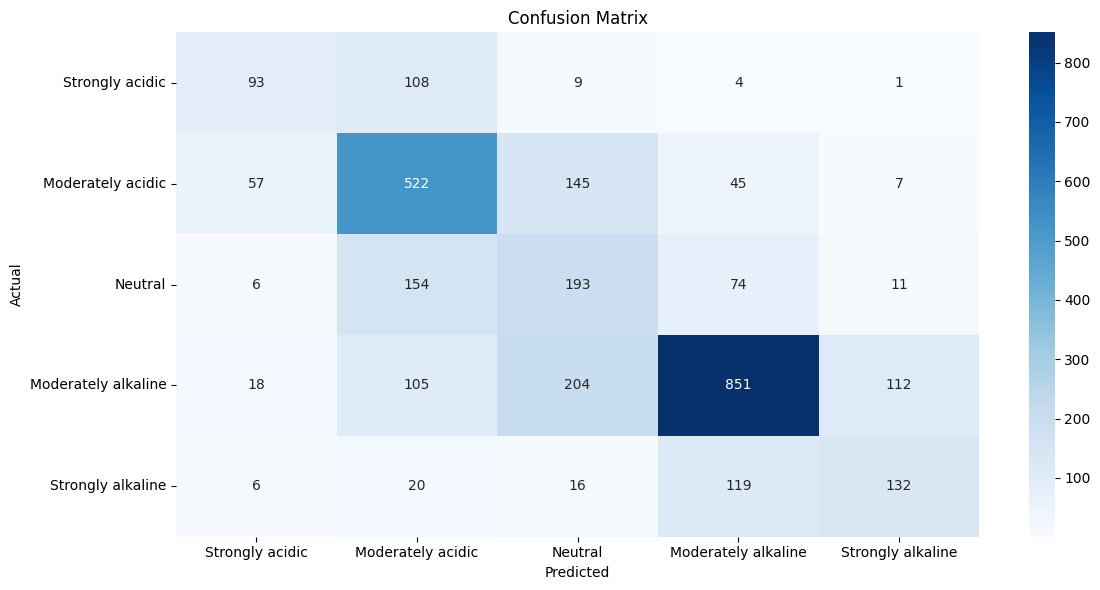

In [ ]:
mapping = {
    "0" : "Strongly acidic",
    "1" : "Moderately acidic",
    "2" : "Neutral",
    "3" : "Moderately alkaline",
    "4" : "Strongly alkaline"
}

plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(y_train, final_preds), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(mapping)) + 0.5, labels=list(mapping.values()), rotation=0)
plt.yticks(ticks=np.arange(len(mapping)) + 0.5, labels=list(mapping.values()), rotation=0)
plt.tight_layout()
plt.show()